<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Lesson3_AdvancedLinreg/ML_AI_Lesson3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Пример бинаризации признаков

Сгенерируем данные

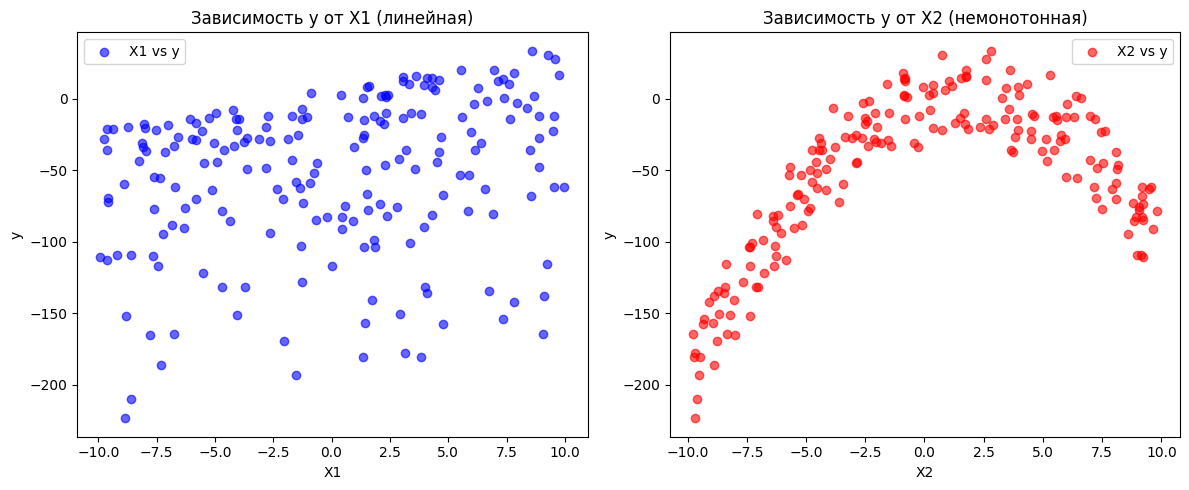

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Параметры
n_samples = 200       # Количество образцов
a = 3.0               # Коэффициент для линейной зависимости
b = 5.0               # Коэффициент для немонотонной зависимости
c = -1.5              # Коэффициент квадратичного члена
noise_std = 5.0       # Стандартное отклонение шума

# Генерация признаков
np.random.seed(0)
X1 = np.random.uniform(-10, 10, n_samples)  # Признак 1 (линейная зависимость с y)
X2 = np.random.uniform(-10, 10, n_samples)  # Признак 2 (немонотонная зависимость с y)

# Генерация целевой переменной
# Линейная часть
y_linear = a * X1

# Нелинейная часть
y_nonlinear = b * X2 + c * X2**2

# Итоговая целевая переменная с шумом
y = y_linear + y_nonlinear + np.random.normal(0, noise_std, n_samples)

# Создание DataFrame для удобства
df = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'y': y
})

# Визуализация
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(df['X1'], df['y'], color='b', alpha=0.6, label='X1 vs y')
plt.xlabel('X1')
plt.ylabel('y')
plt.title('Зависимость y от X1 (линейная)')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(df['X2'], df['y'], color='r', alpha=0.6, label='X2 vs y')
plt.xlabel('X2')
plt.ylabel('y')
plt.title('Зависимость y от X2 (немонотонная)')
plt.legend()

plt.tight_layout()
plt.show()

Обучим классическую линейную регрессию

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Разделение данных на признаки (X) и целевую переменную (y)
X = df[['X1', 'X2']]
y = df['y']

# Разбиение данных на тренировочную и тестовую выборки (80% - обучение, 20% - тест)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Создание и обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Прогнозирование на тестовой выборке
y_pred = model.predict(X_test)

# Вычисление R^2 на тестовой выборке
r2 = r2_score(y_test, y_pred)

print(f"R^2 на тестовой выборке: {r2:.4f}")

R^2 на тестовой выборке: 0.2559


Нужно ли было масштабировать признаки?

## Делаем бинаризацию

In [62]:
# Используем pd.cut для разбиения X2 на 4 равных интервала
X['X2_cut'] = pd.cut(X['X2'], bins=4, labels=['bin1', 'bin2', 'bin3', 'bin4'])

# Используем pd.qcut для разбиения X2 на 4 квантильных интервала (с примерно одинаковым числом значений в каждом)
#df['X2_qcut'] = pd.qcut(df['X2'], q=4, labels=['quartile1', 'quartile2', 'quartile3', 'quartile4'])

# Выводим первые несколько строк для просмотра результата
print(X[['X2', 'X2_cut']].head())

         X2 X2_cut
0 -3.764082   bin2
1  3.926870   bin3
2 -2.444963   bin2
3 -6.407926   bin1
4 -9.506425   bin1


In [63]:
# Применяем One-Hot Encoding к столбцу X2_cut и добавляем новые признаки в исходный DataFrame
X = pd.get_dummies(X, columns=['X2_cut'], prefix='X2_cut', drop_first=False)

# Выводим первые несколько строк для проверки
print(X.head())

         X1        X2  X2_cut_bin1  X2_cut_bin2  X2_cut_bin3  X2_cut_bin4
0  0.976270 -3.764082        False         True        False        False
1  4.303787  3.926870        False        False         True        False
2  2.055268 -2.444963        False         True        False        False
3  0.897664 -6.407926         True        False        False        False
4 -1.526904 -9.506425         True        False        False        False


In [64]:
X.drop('X2', axis=1, inplace=True)

In [65]:
# Разбиение данных на тренировочную и тестовую выборки (80% - обучение, 20% - тест)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Создание и обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Прогнозирование на тестовой выборке
y_pred = model.predict(X_test)

# Вычисление R^2 на тестовой выборке
r2 = r2_score(y_test, y_pred)

print(f"R^2 на тестовой выборке: {r2:.4f}")

R^2 на тестовой выборке: 0.7585


In [66]:
model.coef_

array([  2.56541397, -70.45686712,  21.11598361,  47.64722684,
         1.69365667])

Вопросы на внимательность (и не только):

1) где произошел dataleak? И как нужно было сделать правильно?

2) а где еще был dataleak?

## В принципе иногда можно и проще

In [69]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Разделение данных на признаки и целевую переменную
X = df[['X1', 'X2']]
y = df['y']

# Разбиение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Создание пайплайна с полиномиальными признаками и стандартизацией
pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('linear_regression', LinearRegression())
])

# Обучение модели на тренировочных данных
pipeline.fit(X_train, y_train)

# Прогнозирование на тестовой выборке
y_pred = pipeline.predict(X_test)

# Вычисление R^2 на тестовой выборке
r2 = r2_score(y_test, y_pred)
print(f"R^2 на тестовой выборке: {r2:.4f}")

R^2 на тестовой выборке: 0.9935


In [72]:
import numpy as np

# Извлекаем имена полиномиальных признаков после обучения пайплайна
feature_names = pipeline.named_steps['poly_features'].get_feature_names_out(input_features=X.columns)

# Извлекаем коэффициенты линейной регрессии из обученного пайплайна
coefficients = pipeline.named_steps['linear_regression'].coef_

# Создаем DataFrame для наглядности
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Сортируем по абсолютному значению коэффициента, чтобы увидеть самые важные признаки
feature_importance['Importance'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print(feature_importance[['Feature', 'Coefficient', 'Importance']])

  Feature  Coefficient  Importance
4    X2^2   -42.810204   42.810204
1      X2    29.125103   29.125103
0      X1    17.627359   17.627359
3   X1 X2    -0.368341    0.368341
2    X1^2    -0.313914    0.313914
